# Solving the Traveling Salesman Problem (TSP)

### Models and Methods from Operations Research - Arnau Pérez Reverte, 21/01/2025

### 1. TSP Data

In [1]:
import pandas as pd
import numpy as np
import warnings
import networkx as nx
import matplotlib.pyplot as plt

from amplpy import AMPL, add_to_path, Environment

warnings.filterwarnings("ignore")


from data.generate_dataset import generate_dataset

distance_matrix_df: pd.DataFrame  = generate_dataset("data/instances/coordinates.csv")
distance_matrix: np.ndarray = distance_matrix_df.to_numpy()

In [2]:
distance_matrix_df

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,6.242675,8.460057,14.309490,13.974017,8.934364,11.963422,14.233293,14.117138,6.713621,11.076765,4.268130
2,6.242675,0.000000,8.835749,8.461671,8.096833,6.603899,6.410533,8.333500,8.383265,8.994856,5.042039,9.969501
3,8.460057,8.835749,0.000000,16.319338,15.938099,15.044591,14.816123,16.109470,16.422320,2.705639,12.966294,12.220093
4,14.309490,8.461671,16.319338,0.000000,0.381791,8.243683,2.496254,0.288200,0.552670,17.156021,3.462571,17.210717
5,13.974017,8.096833,15.938099,0.381791,0.000000,8.079354,2.249701,0.275413,0.707631,16.776210,3.087034,16.918281
6,8.934364,6.603899,15.044591,8.243683,8.079354,0.000000,5.901111,8.343210,7.788449,14.506233,6.781800,10.215115
7,11.963422,6.410533,14.816123,2.496254,2.249701,5.901111,0.000000,2.524321,2.185846,15.345909,2.081370,14.734650
8,14.233293,8.333500,16.109470,0.288200,0.275413,8.343210,2.524321,0.000000,0.801200,16.979050,3.309009,17.190810
9,14.117138,8.383265,16.422320,0.552670,0.707631,7.788449,2.185846,0.801200,0.000000,17.174250,3.477163,16.917242
10,6.713621,8.994856,2.705639,17.156021,16.776210,14.506233,15.345909,16.979050,17.174250,0.000000,13.704151,9.997724


### 2. Obtaining an upper bound

In [3]:
from heuristics.christofides import christofides

initial_tour = christofides(distance_matrix=distance_matrix)

In [4]:
from heuristics.two_opt import calculate_tour_length

print("----- CHRISTOFIDES APPROXIMATION -----")
print(f"Tour: {[i+1 for i in initial_tour]}")
print(f"Tour length: {calculate_tour_length(initial_tour, distance_matrix)}")

----- CHRISTOFIDES APPROXIMATION -----
Tour: [1, 12, 6, 7, 9, 4, 8, 5, 11, 2, 10, 3, 1]
Tour length: 51.97610728105589


In [5]:
from heuristics.two_opt import two_opt

improved_tour, improved_length = two_opt(initial_tour, distance_matrix)

In [6]:
print("----- 2-OPT IMPROVEMENT -----")
print(f"Initial tour: {[i+1 for i in initial_tour]}")
print(f"2-Opt improved tour: {[i+1 for i in improved_tour]}")
print(f"2-Opt improved tour length: {improved_length}")
print(
    f"\nImprovement: {(calculate_tour_length(initial_tour, distance_matrix) - improved_length)/calculate_tour_length(initial_tour, distance_matrix)*100} %"
)

----- 2-OPT IMPROVEMENT -----
Initial tour: [1, 12, 6, 7, 9, 4, 8, 5, 11, 2, 10, 3, 1]
2-Opt improved tour: [1, 12, 6, 7, 9, 4, 8, 5, 11, 2, 3, 10, 1]
2-Opt improved tour length: 50.0705650916833

Improvement: 3.6661887337359644 %


### 3. Obtaining a lower bound

### Section a)

In [7]:

AMPL_DIR = None # Set to None if "ampl" is available in the PATH
if AMPL_DIR is not None:
    add_to_path(AMPL_DIR)
ampl = AMPL(Environment(""))
ampl.read("ampl/tsp.mod")
ampl.setOption("solver", "gurobi")

The license for this AMPL processor will expire in 10.2 days.


In [8]:
n = len(distance_matrix_df)
ampl.param["n"] = n
ampl.param["distance_matrix"] = distance_matrix_df
ampl.eval("option gurobi_options 'IntFeasTol=1e-09';")

In [10]:
ampl.solve("Problem_A", solver="gurobi")

assert ampl.solve_result == "solved"

length_objective = ampl.get_objective("Length_Objective")
x = ampl.get_variable("x")
print(f"Length: {length_objective.value()}")

The license for this solver will expire in 10.2 days.
Gurobi 11.0.0:Gurobi 11.0.0: optimal solution; objective 46.8838816
14 simplex iterations
 
Length: 46.88388159822529


In [11]:
def print_solution(df):
    connections = df[df["x.val"] > 0.0].index.to_list()
    connections_values = df[df["x.val"] > 0.0]["x.val"].to_list()
    connections_values = list(map(lambda val: f"-----{val}-----", connections_values))

    plt.figure(figsize=(12, 8), dpi=100)  # Increase figure size and resolution
    G = nx.Graph()
    G.add_edges_from(connections)
    pos = nx.spring_layout(G, seed=50)  # positions for all nodes
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=500,
        font_size=12,
        font_weight="bold",
    )

    edge_labels = dict(zip(connections, connections_values))
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, node_size=500, font_size=10, font_weight='bold')

    # Show the plot
    plt.axis("off")
    plt.tight_layout()
    plt.show()

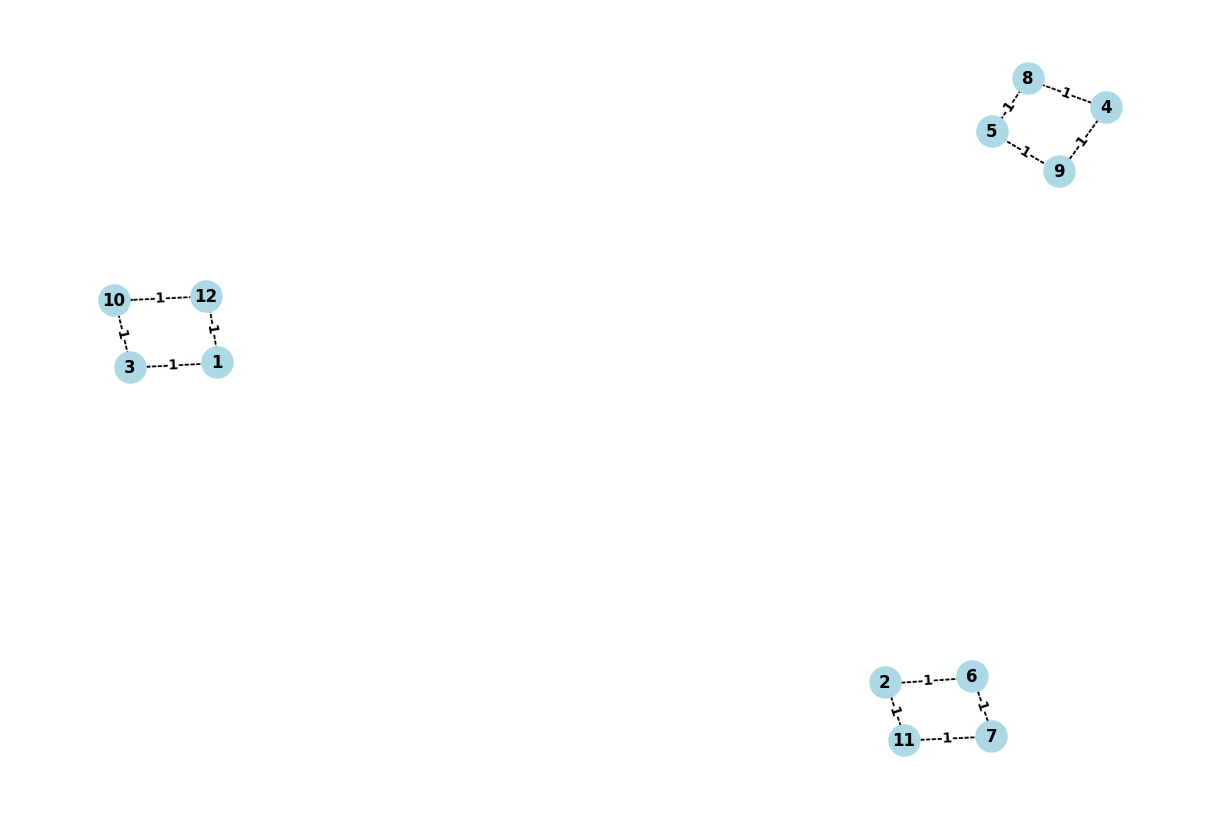

In [12]:
df = x.get_values().to_pandas()
print_solution(df)

### Section b)

In [13]:
num_subtours = 1

subtour_nodes = {
    1: [1,3,10,12],
}

subtour_sizes = {
    1: 4,
}

ampl.param["n_subtours"] = num_subtours
for s, nodes in subtour_nodes.items():
    ampl.getSet("SubtourNodes").set_values({s: nodes})
for s, size in subtour_sizes.items():
    ampl.getParameter("SubtourSize").set_values({s: size})

The license for this solver will expire in 10.2 days.
Gurobi 11.0.0:Gurobi 11.0.0: optimal solution; objective 47.58668732
17 simplex iterations
 


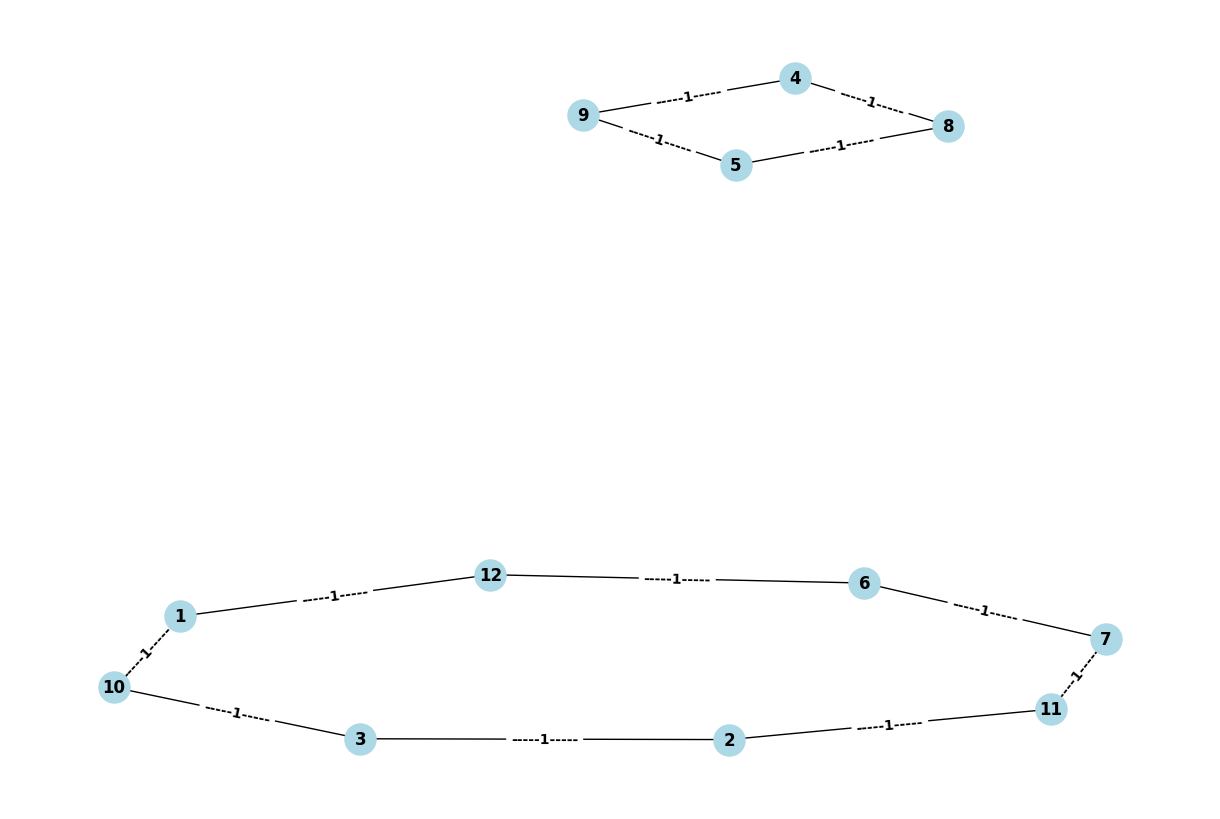

In [15]:
ampl.solve("Problem_B", solver="gurobi")
df = x.get_values().to_pandas()
print_solution(df)

In [16]:
num_subtours = 2

subtour_nodes = {
    1: [1,3,10,12],
    2: [4,5,8,9]
}

subtour_sizes = {
    1: 4,
    2: 4
}


ampl.param["n_subtours"] = num_subtours

for s, nodes in subtour_nodes.items():
    ampl.getSet("SubtourNodes").set_values({s: nodes})
for s, size in subtour_sizes.items():
    ampl.getParameter("SubtourSize").set_values({s: size})

The license for this solver will expire in 10.2 days.
Gurobi 11.0.0:Gurobi 11.0.0: optimal solution; objective 47.8126847
19 simplex iterations
 


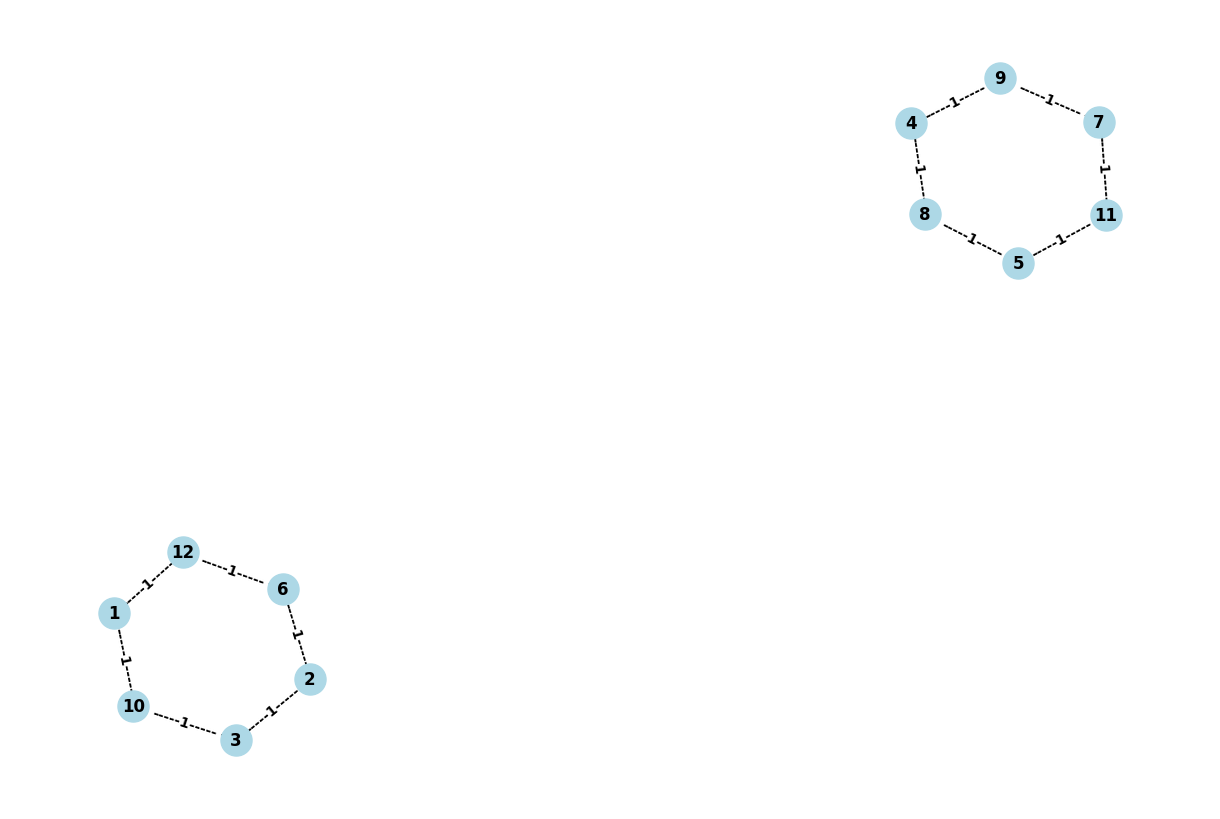

In [17]:
ampl.solve("Problem_B", solver="gurobi")
df = x.get_values().to_pandas()
print_solution(df)

In [18]:
num_subtours = 3

subtour_nodes = {
    1: [1,3,10,12],
    2: [4,5,8,9],
    3: [1,2,3,6,10,12]
}

subtour_sizes = {
    1: 4,
    2: 4,
    3: 6
}

ampl.param["n_subtours"] = num_subtours

for s, nodes in subtour_nodes.items():
    ampl.getSet("SubtourNodes").set_values({s: nodes})
for s, size in subtour_sizes.items():
    ampl.getParameter("SubtourSize").set_values({s: size})

The license for this solver will expire in 10.2 days.
Gurobi 11.0.0:Gurobi 11.0.0: optimal solution; objective 50.07056509
20 simplex iterations
 


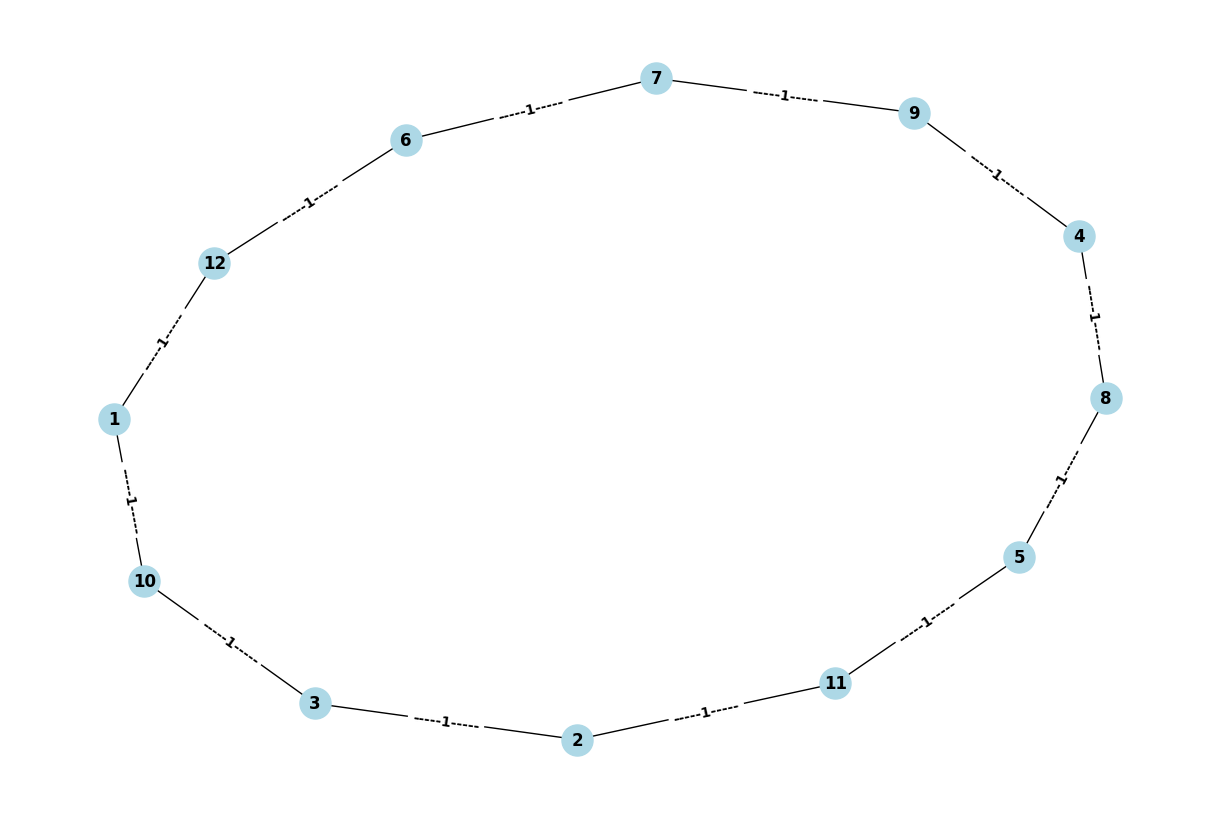

In [19]:
ampl.solve("Problem_B", solver="gurobi")
df = x.get_values().to_pandas()
print_solution(df)

### Section e)

The license for this solver will expire in 10.2 days.
Gurobi 11.0.0:   mip:inttol = 1e-09
Gurobi 11.0.0: optimal solution; objective 50.07056509
19 simplex iterations
1 branching nodes
 


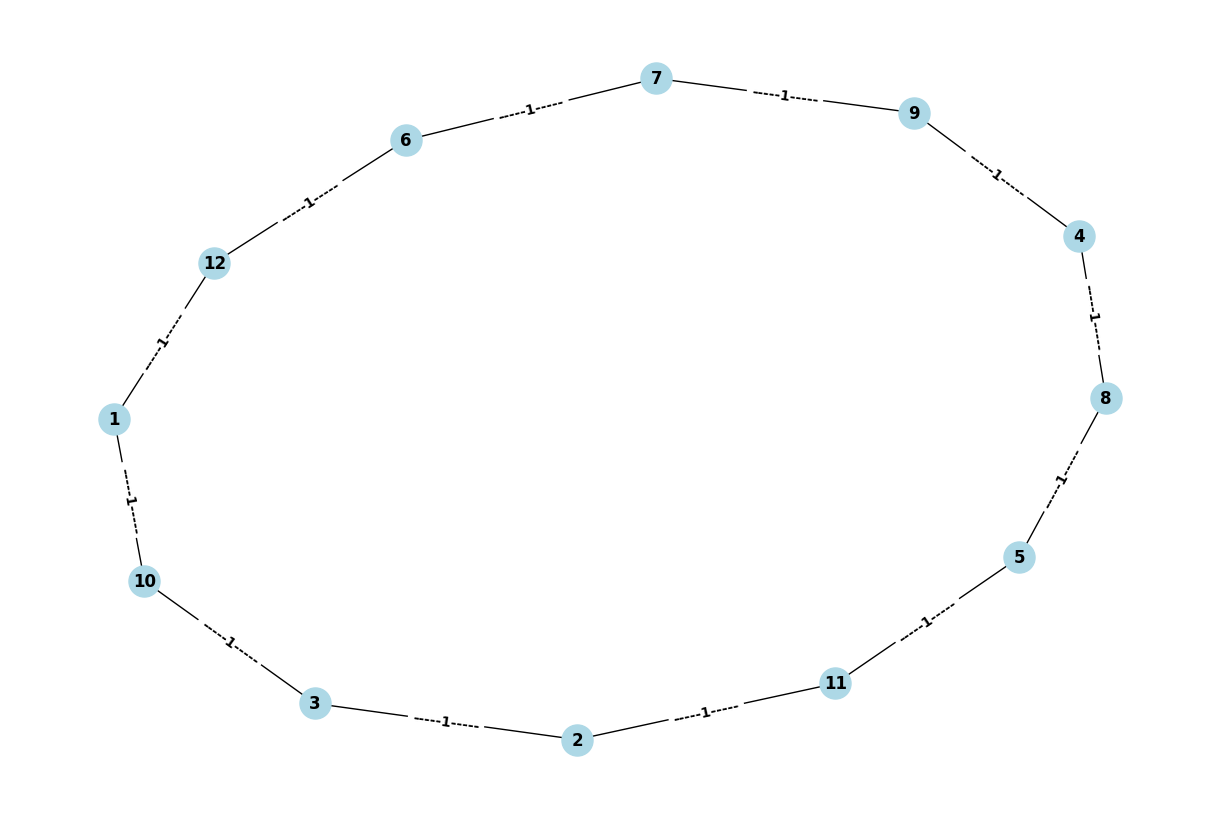

In [20]:
ampl.solve("Problem_C", solver="gurobi")
df = x.get_values().to_pandas()
print_solution(df)